# 1. Perkenalan

Jimmy Jaya Nugraha

## Main Objective
1.   Membuat model deep learning computer vision dengan cnn untuk membedakan sampah yang bisa didaur ulang berdasarkan materialnya

## Sub Objectives
1.   Mempelajari persiapan data yang berupa image dan remote dari kaggle
2.   Melakukan observasi pada penggunaan flow_from_dataframe + ImageDataGenerator dan image_dataset_from_directory serta hasilnya
3.   Mempercepat proses learning dengan prefetch dan cache
4.   Mempelajari layer-layer yang bisa digunakan untuk data-augmentation serta model lainnya seperti Conv2D, BatchNormalization, kernel_regularizer, dll.
5.   Melihat perbedaan data grayscale dengan rgb dalam proses training



# 2. Import library
Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [186]:
# Melakukan Import Library
import os
import shutil
import glob
import numpy as np
import pandas as pd
from google.colab import files
from keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten,RandomZoom,CenterCrop, RandomRotation,Rescaling,RandomFlip, BatchNormalization, Input,CenterCrop
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import Regularizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# 3. Data Loading
Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [8]:
# Membuat folder kaggle di root
!mkdir -p ~/.kaggle 

# Copy paste kaggle.json ke folder kaggle
!cp kaggle.json ~/.kaggle 

# Membuat folder kaggle di lokasi yang sama, namun bukan di root
!mkdir ./kaggle 

# move file kaggle.json ke folder kaggle
!mv ./kaggle.json ./kaggle


mkdir: cannot create directory ‘./kaggle’: File exists


In [9]:
#perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!chmod 600 ~/.kaggle/kaggle.json 

#cek list data yang ada di folder kaggle
!ls ~/.kaggle 


kaggle.json


In [123]:
# Download Dataset dari kaggle
! kaggle datasets download -d asdasdasasdas/garbage-classification

 96% 79.0M/82.0M [00:01<00:00, 64.2MB/s]
100% 82.0M/82.0M [00:01<00:00, 63.3MB/s]


In [152]:
# Melakukan Unzip dan Mengekstraknya ke folder image
!unzip -q /content/garbage-classification.zip -d image 

In [115]:
classes= os.listdir('/content/image/Garbage classification/Garbage classification')
classes

['glass', 'trash', 'paper', 'metal', 'plastic', 'cardboard']

In [13]:
main_path = '/content/image/Garbage classification/Garbage classification'

In [153]:
# Membuat list berisi direktori folder garbage
list_garbage =os.listdir(main_path)

dir_garbage = []
for i in list_garbage:
    dir_garbage.append(os.path.join(main_path, i))

column_name = ['image', 'label']
df_garbage = pd.DataFrame(columns = column_name)
df_garbage

for h,i in enumerate(list_garbage):
    jenis =[]
    for j in os.listdir(dir_garbage[h]):
        jenis.append(os.path.join(dir_garbage[h],j))
    df_jenis = pd.DataFrame(jenis, columns = ['image'])
    df_jenis['label'] = i
    df_garbage = pd.concat([df_garbage, df_jenis], ignore_index=True)
df_garbage.head()

,image,label
0,/content/image/Garbage classification/Garbage ...,glass
1,/content/image/Garbage classification/Garbage ...,glass
2,/content/image/Garbage classification/Garbage ...,glass
3,/content/image/Garbage classification/Garbage ...,glass
4,/content/image/Garbage classification/Garbage ...,glass


# 4. Exploratory Data Analysis (EDA)
Bagian ini berisi explorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.

In [15]:
# Melihat banyaknya data
df_garbage.shape

(2527, 2)

In [16]:
# Melihat banyaknya data untuk setiap jenis garbage
df_garbage['label'].value_counts()

paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: label, dtype: int64

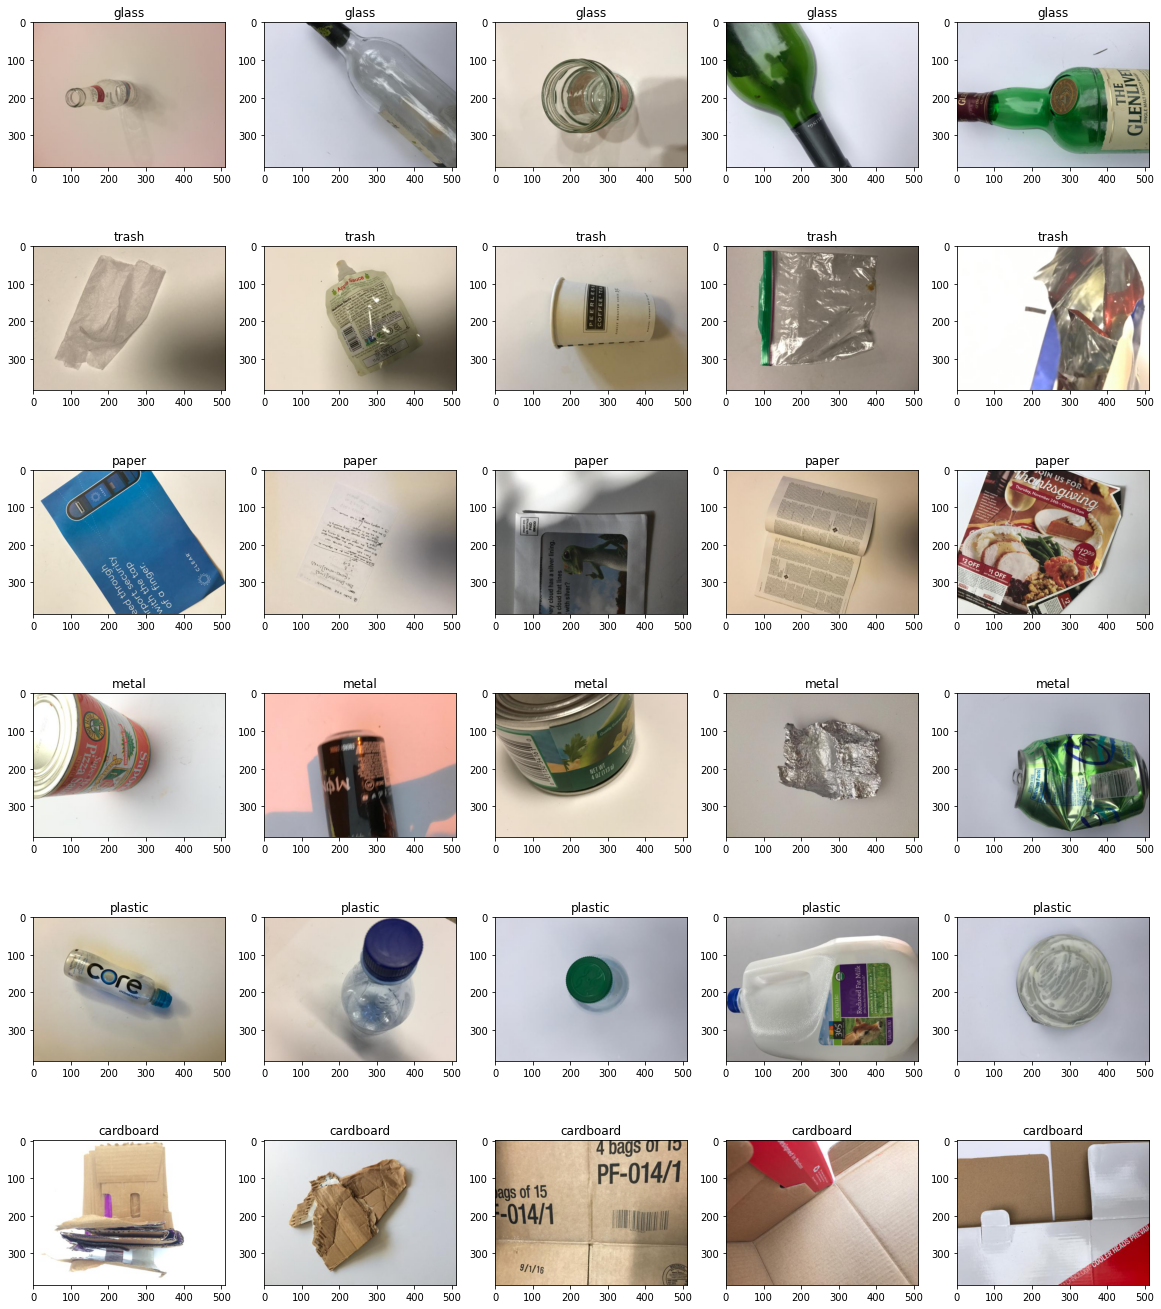

In [107]:
# Menampilkan contoh setiap jenis garbage
ncol=5 #ini jumlah sample untuk setiap class
nrow=len(list_garbage)

# Membuat dataframe sample garbage
sample_garbage = pd.DataFrame(columns=['image','label'])
for i in list_garbage:
  df_sampling = df_garbage[df_garbage['label']==i].sample(ncol)
  sample_garbage = pd.concat([sample_garbage,df_sampling],ignore_index=True)
sample_garbage

# melist semua subplots
axes=[]
for x in range(nrow):
    for y in range(ncol):
        axes.append((x,y))

# menampilkan sample setiap jenis garbage
fig, ax = plt.subplots(ncols=ncol,nrows=nrow, figsize=(4*ncol,4*nrow))
for h,i in enumerate(sample_garbage['label']):
    ax[axes[h]].imshow(plt.imread(sample_garbage['image'][h]))
    ax[axes[h]].set_title(i)
    # ax[axes[h]].axis('off')
plt.show()

Terlihat terdapat 6 kelas yang terdiri dari 6 kelas yang masing-masing berisi sampah daur ulang dengan material yang berbeda. Kecuali pada kelas trash yang terdiri dari material yang tidak dapat didaur ulang seperti styrofoam dll.

In [44]:
# making n X m matrix
def img2np(list_of_filepath, size = (300, 300)):
    # iterating through each file
    for fp in list_of_filepath:
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # convert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [45]:
# Menjadikan setiap class ke df terpisah 
df_glass = df_garbage[df_garbage['label']=='glass']
df_trash = df_garbage[df_garbage['label']=='trash']
df_paper = df_garbage[df_garbage['label']=='paper']
df_metal = df_garbage[df_garbage['label']=='glass']
df_plastic = df_garbage[df_garbage['label']=='plastic']
df_cardboard = df_garbage[df_garbage['label']=='cardboard']

# menjadikan ke matrix
mat_glass = img2np(df_glass['image'])
mat_trash = img2np(df_trash['image'])
mat_paper = img2np(df_paper['image'])
mat_metal = img2np(df_metal['image'])
mat_plastic = img2np(df_glass['image'])
mat_cardboard = img2np(df_glass['image'])

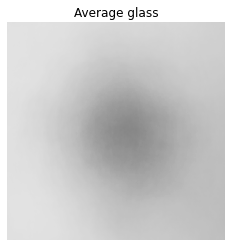

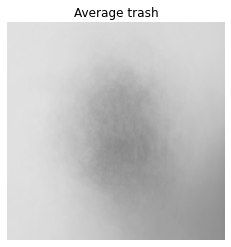

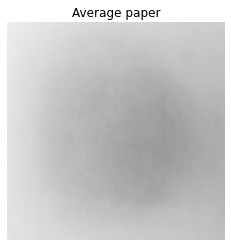

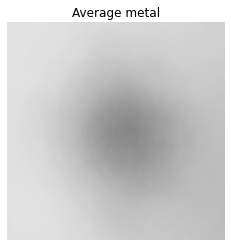

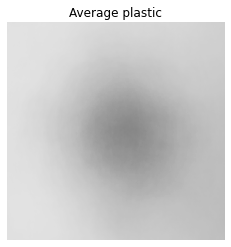

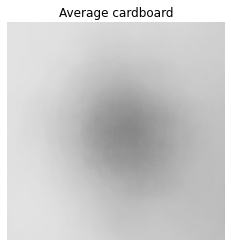

In [50]:
# Membuat fungsi untuk melihat mean dari gambar
def find_mean_img(full_mat, title, size = (300, 300)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

mean_glass = find_mean_img(mat_glass, 'glass')
mean_trash = find_mean_img(mat_trash, 'trash')
mean_paper = find_mean_img(mat_paper, 'paper')
mean_metal = find_mean_img(mat_metal, 'metal')
mean_plastic = find_mean_img(mat_plastic, 'plastic')
mean_cardboard = find_mean_img(mat_cardboard, 'cardboard')


> terlihat kalau mean gambarnya dari setiap kelas memiliki mean yang berbeda-beda, namun dapat terlihat memiliki kecenderungan terdapat pada posisi tengah gambar, kecuali pada class paper yang terlihat menyebar

# 5. Data Preprocessing
Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-dev-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

## Data Splitting

In [154]:
# Mendefinisikan variabel target
target = 'label'
df = df_garbage

# Memisahkan Inference-set from dataset
df_inf =df.sample(5, random_state=25)

# Mendrop data yang dijadikan df_inf dan reset index
df_tanpa_inf=df.drop(df_inf.index)
df_tanpa_inf.reset_index(drop=True, inplace=True)

# Membagi ke data train, test, dan val
df_train, df_test = train_test_split(df_tanpa_inf, test_size=0.2, random_state=25, stratify = df_tanpa_inf[target])
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=25, stratify = df_train[target])

# Mereset index 
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)

# Melihat jumlah train set dan test set
print('df_train :',df_train.shape)
print('df_val :',df_val.shape)
print('df_test :',df_test.shape)
print('df_inf :',df_inf.shape)

df_train : (1411, 2)
df_val : (606, 2)
df_test : (505, 2)
df_inf : (5, 2)


## Membuat Dataframe berisi direktori files yang digunakan

In [155]:
df_train.head()

,image,label
0,/content/image/Garbage classification/Garbage ...,paper
1,/content/image/Garbage classification/Garbage ...,metal
2,/content/image/Garbage classification/Garbage ...,cardboard
3,/content/image/Garbage classification/Garbage ...,plastic
4,/content/image/Garbage classification/Garbage ...,glass


In [157]:
# memisahkan file ke dalam folder agar dapat menggunakan flow_from directory
data =[df_train, df_test, df_val, df_inf]
for df in data:
  # membagi direktori
  first_dir=[]
  name = []
  for j in df['image']:
    first_dir.append(main_path)
    name.append(j.split('/')[-1])
  df['first_dir']=first_dir
  df['name']=name

# membuat direktori baru untuk move
#train
new_image=[]
for k, l in enumerate(df_train['label']):
  new_image.append(os.path.join(df_train['first_dir'][k],'train',l,df_train['name'][k]))
df_train['new_image']= new_image

#test
new_image=[]
for k, l in enumerate(df_test['label']):
  new_image.append(os.path.join(df_test['first_dir'][k],'test',l,df_test['name'][k]))
df_test['new_image']= new_image

#val
new_image=[]
for k, l in enumerate(df_val['label']):
  new_image.append(os.path.join(df_val['first_dir'][k],'val',l,df_val['name'][k]))
df_val['new_image']= new_image

#inf
new_image=[]
for k, l in enumerate(df_inf['label']):
  new_image.append(os.path.join(df_inf['first_dir'][k],'inf',l,df_inf['name'][k]))
df_inf['new_image']= new_image

In [158]:
df_train.head()

,image,label,first_dir,name,new_image
0,/content/image/Garbage classification/Garbage ...,paper,/content/image/Garbage classification/Garbage ...,paper313.jpg,/content/image/Garbage classification/Garbage ...
1,/content/image/Garbage classification/Garbage ...,metal,/content/image/Garbage classification/Garbage ...,metal97.jpg,/content/image/Garbage classification/Garbage ...
2,/content/image/Garbage classification/Garbage ...,cardboard,/content/image/Garbage classification/Garbage ...,cardboard110.jpg,/content/image/Garbage classification/Garbage ...
3,/content/image/Garbage classification/Garbage ...,plastic,/content/image/Garbage classification/Garbage ...,plastic57.jpg,/content/image/Garbage classification/Garbage ...
4,/content/image/Garbage classification/Garbage ...,glass,/content/image/Garbage classification/Garbage ...,glass83.jpg,/content/image/Garbage classification/Garbage ...


## Melakukan Persiapan Data Training Dengan Flow From DataFrame


In [24]:
# Mengatur ukuran input
img_height = 300
img_width = 300
SEED = 22 #ini sama seperti random_state
BATCH = 32

np.random.seed(42) # cara supaya outputnya stabil
tf.random.set_seed(42) # ini cara bikin outputnya stabil

In [25]:
# Augmentasi data
# menggunakan image data generator dari tensorflow
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [26]:
ds_train_df = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    class_mode='categorical',
    color_mode ='rgb')

ds_val_df = vaL_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    color_mode ='rgb')

ds_test_df = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    color_mode ='rgb')


Found 1411 validated image filenames belonging to 6 classes.
Found 606 validated image filenames belonging to 6 classes.
Found 505 validated image filenames belonging to 6 classes.


In [27]:
# cek kelasnya
ds_train_df.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

## Melakukan Persiapan Data Training Dengan image_dataset_from_directory dan Prefetch




In [159]:
# Membuat direktori baru
for jenis in ['train','test','val', 'inf']:
  for i in classes:
    os.makedirs(os.path.join(main_path,jenis,i))


In [160]:
# move direktori
for df in data: 
  for k,l in enumerate(df['image']):
    shutil.move(l,df['new_image'][k])

In [112]:
# menghapus direktori kosong
for i in classes:
  shutil.rmtree(os.path.join(main_path,i))

In [ ]:
# Mengatur ukuran input dan random seed
img_height = 300
img_width = 300
SEED = 27 
BATCH = 32

np.random.seed(27) # cara supaya outputnya stabil
tf.random.set_seed(27) # ini cara bikin outputnya stabil

In [ ]:
# Mengenerate data dari image yang ada di direktori
ds_train = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'train'),
    image_size=(img_height, img_width), 
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')

ds_val = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'val'),
    image_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')

ds_test = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'test'),
    image_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')


Found 1411 files belonging to 6 classes.
Found 606 files belonging to 6 classes.
Found 505 files belonging to 6 classes.


In [ ]:
# melihat list kelas yang ada
ds_train.class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

PERHATIAN: Pada bagian image dataset from direktori, proses Normalisasi akan dilakukan di layer pertama pada model, karena memang tidak ada parameternya di syntax tersebut.

In [ ]:
# Menggunakan autotune, cache, dan prefetch untuk mempercepat proses training

AUTOTUNE = tf.data.AUTOTUNE

ds_train_prefetch = ds_train.shuffle(200).cache().prefetch(buffer_size=AUTOTUNE)
ds_test_prefetch = ds_test.cache().prefetch(buffer_size=AUTOTUNE)
ds_val_prefetch = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

# 6. Model Definition, Training, And Evaluation
Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

## Model dari data yang disiapkan dengan image_dataset_from_directory 

In [33]:
# Membuat fungsi untuk menggambar grafik loss dan akurasi training
def loss_accuracy(history_list):
  overall_history=pd.DataFrame(columns=['loss','accuracy', 'val_loss', 'val_accuracy'])
  for i in history_list:
    df = pd.DataFrame(i.history)
    overall_history = pd.concat([overall_history,df], ignore_index=True)

  plt.subplots(ncols=2 ,figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(overall_history['loss'])
  plt.plot(overall_history['val_loss'])
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.subplot(1,2,2)
  plt.plot(overall_history['accuracy'])
  plt.plot(overall_history['val_accuracy'])
  plt.title('accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()

In [ ]:
# Model building
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

model_1a = Sequential()
# Conv 1
model_1a.add(Rescaling(1./255, input_shape=input))
model_1a.add(Conv2D(filters = 32, kernel_size =3, activation ='relu', padding='same', input_shape=input))
model_1a.add(MaxPooling2D(pool_size=2 )) 

#Conv 2
model_1a.add(Conv2D(filters = 64, kernel_size =3,  activation ='relu',padding='same')) 
model_1a.add(MaxPooling2D(pool_size=2)) 

#Conv 3
model_1a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
model_1a.add(MaxPooling2D(pool_size=2)) 


#Conv 4
model_1a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
model_1a.add(MaxPooling2D(pool_size=2)) 


#Flatten
model_1a.add(Flatten())
model_1a.add(Dense(units=64, activation='relu'))

model_1a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_1a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

# callbacks
callback_1a = [ModelCheckpoint('model_1.hdf5', monitor = 'val_accuracy', save_best_only =True)]

In [ ]:
# proses training
history_1a = model_1a.fit(ds_train_prefetch, batch_size = BATCH, epochs =10, validation_data=ds_val_prefetch, callbacks=callback_1a, verbose = 1)

Epoch 1/10
45/45 [==============================] - 17s 92ms/step - loss: 1.6625 - accuracy: 0.2757 - val_loss: 1.5305 - val_accuracy: 0.3449
Epoch 2/10
45/45 [==============================] - 3s 60ms/step - loss: 1.4446 - accuracy: 0.4153 - val_loss: 1.4041 - val_accuracy: 0.4175
Epoch 3/10
45/45 [==============================] - 3s 60ms/step - loss: 1.2951 - accuracy: 0.4812 - val_loss: 1.2600 - val_accuracy: 0.5248
Epoch 4/10
45/45 [==============================] - 3s 59ms/step - loss: 1.2105 - accuracy: 0.5301 - val_loss: 1.2185 - val_accuracy: 0.4950
Epoch 5/10
45/45 [==============================] - 3s 60ms/step - loss: 1.0674 - accuracy: 0.5811 - val_loss: 1.1546 - val_accuracy: 0.5842
Epoch 6/10
45/45 [==============================] - 3s 59ms/step - loss: 0.9311 - accuracy: 0.6520 - val_loss: 1.2308 - val_accuracy: 0.5462
Epoch 7/10
45/45 [==============================] - 3s 58ms/step - loss: 0.7967 - accuracy: 0.6988 - val_loss: 1.4104 - val_accuracy: 0.5297
Epoch 8/10
4

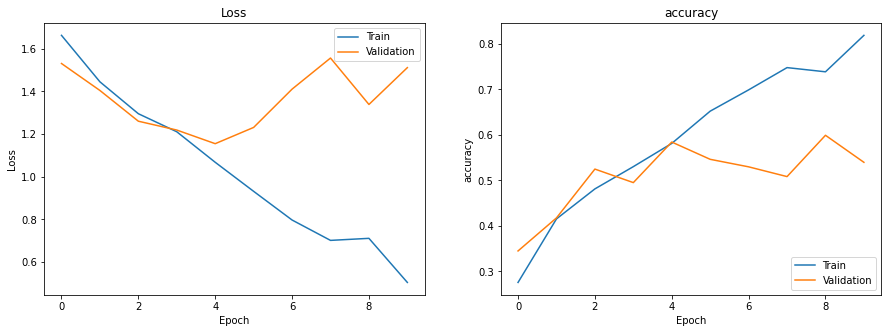

In [ ]:
loss_accuracy([history_1a])

Model di atas menghasilkan akurasi yang semakin overfit, maka akan ditambah layer dropoff

In [ ]:
# Model_building
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

model_2a = Sequential()
# Conv 1
# model_2a.add(CenterCrop(height =300, width=300, input_shape=input))
# model_2a.add(Resizing(300,300,input_shape=input))
model_2a.add(Rescaling(1./255, input_shape=input))
model_2a.add(Conv2D(filters = 32, kernel_size =3, activation ='relu', padding='same', input_shape=input))
# model_2a.add(BatchNormalization())
model_2a.add(MaxPooling2D(pool_size=2 )) 
model_2a.add(Dropout(0.3))

#Conv 2
model_2a.add(Conv2D(filters = 64, kernel_size =3,  activation ='relu',padding='same')) 
# model_2a.add(BatchNormalization())
model_2a.add(MaxPooling2D(pool_size=2)) 
model_2a.add(Dropout(0.3))

#Conv 3
model_2a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
# model_2a.add(BatchNormalization())
model_2a.add(MaxPooling2D(pool_size=2)) 
model_2a.add(Dropout(0.3))

#Conv 4
model_2a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
# model_2a.add(BatchNormalization())
model_2a.add(MaxPooling2D(pool_size=2)) 
model_2a.add(Dropout(0.3))

#Flatten
model_2a.add(Flatten())
model_2a.add(Dense(units=64, activation='relu'))
model_2a.add(Dropout(0.20))
model_2a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_2a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# training
callback_2a = [
              # EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, verbose = 1),
              ModelCheckpoint('model_2a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_2a = model_2a.fit(ds_train_prefetch, batch_size = BATCH, epochs =10, validation_data=ds_val_prefetch, callbacks=callback_2a, verbose = 1)

Epoch 1/10
45/45 [==============================] - 4s 68ms/step - loss: 1.8082 - accuracy: 0.2360 - val_loss: 1.7736 - val_accuracy: 0.1964
Epoch 2/10
45/45 [==============================] - 3s 66ms/step - loss: 1.7084 - accuracy: 0.2410 - val_loss: 1.7715 - val_accuracy: 0.2838
Epoch 3/10
45/45 [==============================] - 3s 65ms/step - loss: 1.6399 - accuracy: 0.3097 - val_loss: 1.7130 - val_accuracy: 0.2904
Epoch 4/10
45/45 [==============================] - 3s 65ms/step - loss: 1.5200 - accuracy: 0.3735 - val_loss: 1.5644 - val_accuracy: 0.3515
Epoch 5/10
45/45 [==============================] - 3s 66ms/step - loss: 1.4673 - accuracy: 0.3997 - val_loss: 1.5258 - val_accuracy: 0.4389
Epoch 6/10
45/45 [==============================] - 3s 65ms/step - loss: 1.4092 - accuracy: 0.4259 - val_loss: 1.5091 - val_accuracy: 0.3845
Epoch 7/10
45/45 [==============================] - 3s 65ms/step - loss: 1.4492 - accuracy: 0.4047 - val_loss: 1.4809 - val_accuracy: 0.4703
Epoch 8/10
45

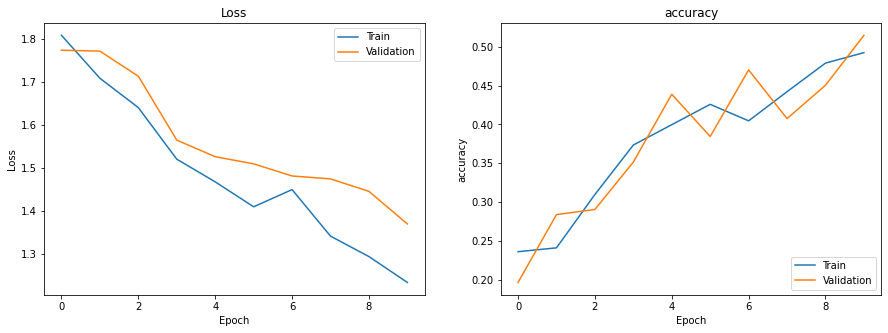

In [ ]:
loss_accuracy([history_2a])

terlihat model masih bisa diteruskan, maka akan dilanjutkan proses training hingga epoch 100 dengan early stopping

In [ ]:
# training kedua
callback_2b = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_2b.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_2b = model_2a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_2b, verbose = 1)

Epoch 1/100
45/45 [==============================] - 3s 66ms/step - loss: 1.2048 - accuracy: 0.5167 - val_loss: 1.4076 - val_accuracy: 0.4917
Epoch 2/100
45/45 [==============================] - 3s 65ms/step - loss: 1.1506 - accuracy: 0.5485 - val_loss: 1.3566 - val_accuracy: 0.5297
Epoch 3/100
45/45 [==============================] - 3s 65ms/step - loss: 1.1175 - accuracy: 0.5521 - val_loss: 1.3763 - val_accuracy: 0.5429
Epoch 4/100
45/45 [==============================] - 3s 63ms/step - loss: 1.1035 - accuracy: 0.5748 - val_loss: 1.5942 - val_accuracy: 0.4010
Epoch 5/100
45/45 [==============================] - 3s 64ms/step - loss: 1.0314 - accuracy: 0.6067 - val_loss: 1.4122 - val_accuracy: 0.4719
Epoch 6/100
45/45 [==============================] - 3s 64ms/step - loss: 0.9893 - accuracy: 0.6102 - val_loss: 1.3214 - val_accuracy: 0.5347
Epoch 7/100
45/45 [==============================] - 3s 63ms/step - loss: 0.9417 - accuracy: 0.6336 - val_loss: 1.3625 - val_accuracy: 0.5330
Epoch 

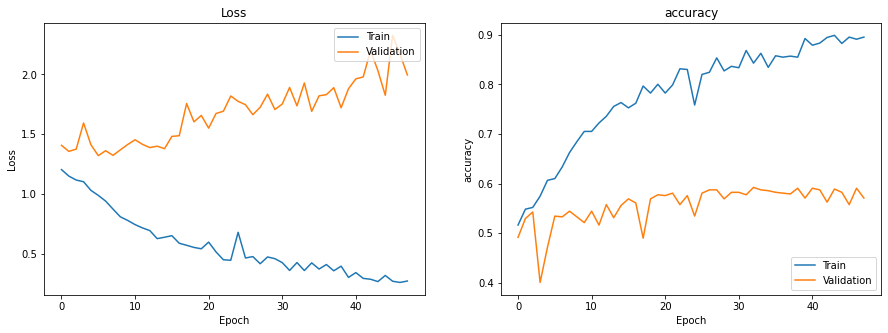

In [ ]:
loss_accuracy([history_2b])

terlihat model sangat overfit, maka akan ditambah jumlah dropoutnya dan juga dilakukan penambahan layer random

In [ ]:
# Model ketiga
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

model_3a = Sequential()
# Conv 1
# model_3a.add(CenterCrop(height =300, width=300, input_shape=input))
# model_3a.add(Resizing(300,300,input_shape=input))
model_3a.add(Rescaling(1./255, input_shape=input))
model_3a.add(RandomRotation(90))
model_3a.add(RandomFlip())
model_3a.add(Conv2D(filters = 32, kernel_size =3, activation ='relu', padding='same', input_shape=input))
# model_3a.add(BatchNormalization())
model_3a.add(MaxPooling2D(pool_size=2 )) 
model_3a.add(Dropout(0.45))

#Conv 2
model_3a.add(Conv2D(filters = 64, kernel_size =3,  activation ='relu',padding='same')) 
# model_3a.add(BatchNormalization())
model_3a.add(MaxPooling2D(pool_size=2)) 
model_3a.add(Dropout(0.45))

#Conv 3
model_3a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
# model_3a.add(BatchNormalization())
model_3a.add(MaxPooling2D(pool_size=2)) 
model_3a.add(Dropout(0.45))

#Conv 4
model_3a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
# model_3a.add(BatchNormalization())
model_3a.add(MaxPooling2D(pool_size=2)) 
model_3a.add(Dropout(0.45))

#Flatten
model_3a.add(Flatten())
model_3a.add(Dense(units=64, activation='relu'))
model_3a.add(Dropout(0.30))
model_3a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_3a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# training
callback_3a = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_3a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_3a = model_3a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_3a, verbose = 1)

Epoch 1/100
45/45 [==============================] - 5s 73ms/step - loss: 1.7795 - accuracy: 0.2190 - val_loss: 1.7828 - val_accuracy: 0.2393
Epoch 2/100
45/45 [==============================] - 3s 69ms/step - loss: 1.7176 - accuracy: 0.2296 - val_loss: 1.7800 - val_accuracy: 0.2277
Epoch 3/100
45/45 [==============================] - 3s 68ms/step - loss: 1.6800 - accuracy: 0.2877 - val_loss: 1.7729 - val_accuracy: 0.1617
Epoch 4/100
45/45 [==============================] - 3s 70ms/step - loss: 1.6128 - accuracy: 0.3267 - val_loss: 1.6612 - val_accuracy: 0.3185
Epoch 5/100
45/45 [==============================] - 3s 69ms/step - loss: 1.5619 - accuracy: 0.3260 - val_loss: 1.6251 - val_accuracy: 0.3647
Epoch 6/100
45/45 [==============================] - 3s 68ms/step - loss: 1.5586 - accuracy: 0.3366 - val_loss: 1.6270 - val_accuracy: 0.3614
Epoch 7/100
45/45 [==============================] - 3s 70ms/step - loss: 1.5150 - accuracy: 0.3650 - val_loss: 1.6108 - val_accuracy: 0.3746
Epoch 

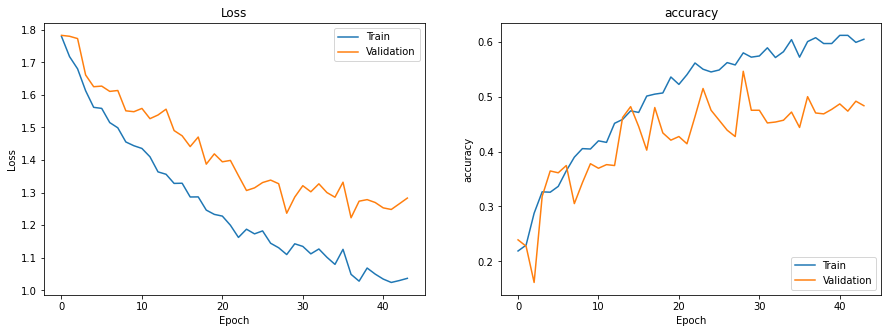

In [ ]:
loss_accuracy([history_3a])

In [ ]:
# Mengembalikan label y_test dari batchdataset
y_test = np.argmax(np.concatenate([y for x, y in ds_test], axis=0),axis=1)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
class_names = ds_train.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# melihat classification report
y_pred_3a = model_3a.predict(ds_test)
y_pred_3a = np.argmax(y_pred_3a, axis=1)
print(classification_report(y_test,y_pred_3a))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        81
           1       0.46      0.46      0.46        99
           2       0.46      0.29      0.36        82
           3       0.40      0.76      0.52       119
           4       0.75      0.03      0.06        97
           5       0.32      0.70      0.44        27

    accuracy                           0.47       505
   macro avg       0.55      0.49      0.43       505
weighted avg       0.56      0.47      0.43       505



perlu pengembangan lagi dari modelnya karena nilai metrik f1 scorenya masih kurang



In [ ]:
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

model_4a = Sequential()
model_4a.add(Rescaling(1./255, input_shape=input))
model_4a.add(RandomRotation(90))
model_4a.add(RandomFlip())
model_4a.add(Conv2D(filters = 50, kernel_size =3, activation ='relu', padding='same', input_shape=input))
model_4a.add(BatchNormalization())
model_4a.add(MaxPooling2D(pool_size=2 )) 
model_4a.add(Dropout(0.50))

#Conv 2
model_4a.add(Conv2D(filters = 80, kernel_size =3,  activation ='relu',padding='same')) 
model_4a.add(BatchNormalization())
model_4a.add(MaxPooling2D(pool_size=2)) 
model_4a.add(Dropout(0.50))

#Conv 3
model_4a.add(Conv2D(filters = 50, kernel_size =3,  activation ='relu',padding='same')) 
model_4a.add(BatchNormalization())
model_4a.add(MaxPooling2D(pool_size=2)) 
model_4a.add(Dropout(0.50))

#Conv 4
model_4a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
model_4a.add(BatchNormalization())
model_4a.add(MaxPooling2D(pool_size=2)) 
model_4a.add(Dropout(0.50))

#Flatten
model_4a.add(Flatten())
model_4a.add(Dense(units=80, activation='relu'))
model_4a.add(Dropout(0.30))
model_4a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_4a.compile(optimizer='RMSProp', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# callbacks
callback_4a = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_4a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_4a = model_4a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_4a, verbose = 1)

Epoch 1/100
45/45 [==============================] - 10s 142ms/step - loss: 3.1039 - accuracy: 0.3168 - val_loss: 5.0917 - val_accuracy: 0.0693
Epoch 2/100
45/45 [==============================] - 5s 115ms/step - loss: 1.6806 - accuracy: 0.3607 - val_loss: 4.5459 - val_accuracy: 0.1964
Epoch 3/100
45/45 [==============================] - 5s 114ms/step - loss: 1.6822 - accuracy: 0.3522 - val_loss: 2.5643 - val_accuracy: 0.1518
Epoch 4/100
45/45 [==============================] - 5s 114ms/step - loss: 1.6395 - accuracy: 0.3863 - val_loss: 3.4720 - val_accuracy: 0.0776
Epoch 5/100
45/45 [==============================] - 5s 116ms/step - loss: 1.5629 - accuracy: 0.4061 - val_loss: 3.5830 - val_accuracy: 0.2277
Epoch 6/100
45/45 [==============================] - 5s 114ms/step - loss: 1.5024 - accuracy: 0.4181 - val_loss: 4.9023 - val_accuracy: 0.1931
Epoch 7/100
45/45 [==============================] - 5s 115ms/step - loss: 1.5012 - accuracy: 0.4444 - val_loss: 5.5966 - val_accuracy: 0.240

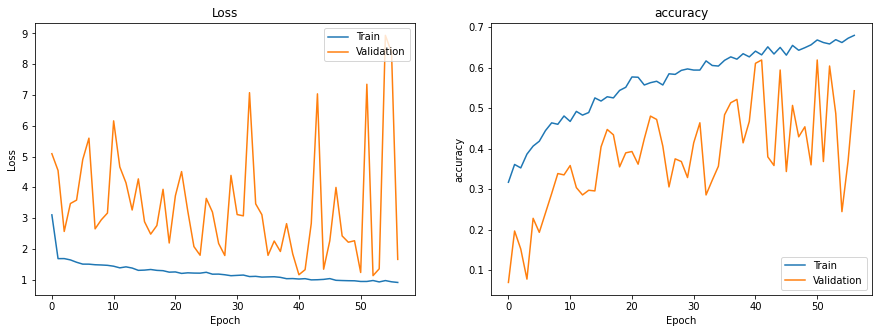

In [ ]:
loss_accuracy([history_4a])

ternyata menggunakan batch normalization memperburuk model, maka akan dihilangkan parameter batch normalizationnya.

In [ ]:
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

model_5a = Sequential()
model_5a.add(Rescaling(1./255, input_shape=input))
model_5a.add(RandomRotation(90))
model_5a.add(RandomFlip())
model_5a.add(Conv2D(filters = 50, kernel_size =3, activation ='relu', padding='same', input_shape=input))
model_5a.add(MaxPooling2D(pool_size=2 )) 
model_5a.add(Dropout(0.50))

#Conv 2
model_5a.add(Conv2D(filters = 80, kernel_size =3,  activation ='relu',padding='same')) 
model_5a.add(MaxPooling2D(pool_size=2)) 
model_5a.add(Dropout(0.50))

#Conv 3
model_5a.add(Conv2D(filters = 50, kernel_size =3,  activation ='relu',padding='same')) 
model_5a.add(MaxPooling2D(pool_size=2)) 
model_5a.add(Dropout(0.50))

#Conv 4
model_5a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
model_5a.add(MaxPooling2D(pool_size=2)) 
model_5a.add(Dropout(0.50))

#Flatten
model_5a.add(Flatten())
model_5a.add(Dense(units=80, activation='relu'))
model_5a.add(Dropout(0.30))
model_5a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_5a.compile(optimizer='RMSProp', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# callbacks
callback_5a = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_5a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_5a = model_5a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_5a, verbose = 1)

Epoch 1/100
45/45 [==============================] - 7s 113ms/step - loss: 1.9573 - accuracy: 0.2218 - val_loss: 1.7864 - val_accuracy: 0.2343
Epoch 2/100
45/45 [==============================] - 5s 114ms/step - loss: 1.7403 - accuracy: 0.2374 - val_loss: 1.7548 - val_accuracy: 0.3333
Epoch 3/100
45/45 [==============================] - 5s 122ms/step - loss: 1.6710 - accuracy: 0.2977 - val_loss: 1.7423 - val_accuracy: 0.3234
Epoch 4/100
45/45 [==============================] - 5s 106ms/step - loss: 1.6009 - accuracy: 0.3274 - val_loss: 1.6925 - val_accuracy: 0.3284
Epoch 5/100
45/45 [==============================] - 5s 101ms/step - loss: 1.5505 - accuracy: 0.3253 - val_loss: 1.6536 - val_accuracy: 0.3383
Epoch 6/100
45/45 [==============================] - 5s 100ms/step - loss: 1.5448 - accuracy: 0.3622 - val_loss: 1.5911 - val_accuracy: 0.3647
Epoch 7/100
45/45 [==============================] - 4s 99ms/step - loss: 1.4841 - accuracy: 0.3841 - val_loss: 1.5823 - val_accuracy: 0.3168


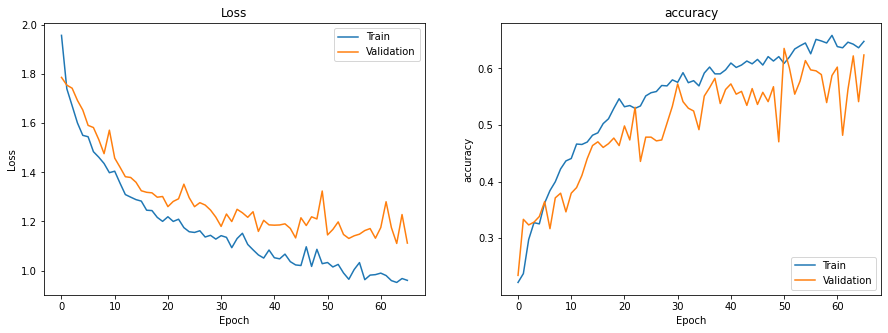

In [ ]:
loss_accuracy([history_5a])

Terlihat modelnya tidak naik dari segi accuracynya, maka akan dicoba menggunakan augmentasi data dan penempatan ulang layer randomnya. Dan akan dicoba menggunakan

In [ ]:
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

#data augmentation
data_augmentation = keras.Sequential(
  [RandomFlip("horizontal", input_shape=input),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ])

#Model Architecture
model_6a = Sequential()
data_augmentation,
model_6a.add(Rescaling(1./255, input_shape=input))

#Conv 1
model_6a.add(Conv2D(filters = 50, kernel_size =3, activation ='relu',
                    padding='valid',kernel_regularizer= tf.keras.regularizers.L2(0.01),
                    input_shape=input))
model_6a.add(MaxPooling2D(pool_size=2 )) 
model_6a.add(Dropout(0.4))

#Conv 2
model_6a.add(Conv2D(filters = 80, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_6a.add(MaxPooling2D(pool_size=2)) 
model_6a.add(Dropout(0.4))

#Conv 3
model_6a.add(Conv2D(filters = 50, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_6a.add(MaxPooling2D(pool_size=2)) 
model_6a.add(Dropout(0.4))

#Conv 4
model_6a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_6a.add(MaxPooling2D(pool_size=2)) 
model_6a.add(Dropout(0.4))

#Flatten
model_6a.add(Flatten())
model_6a.add(Dense(units=80, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_6a.add(Dropout(0.30))
model_6a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_6a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# callbacks
callback_6a = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_6a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_6a = model_6a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_6a, verbose = 1)

Epoch 1/100
45/45 [==============================] - 5s 96ms/step - loss: 4.3156 - accuracy: 0.1821 - val_loss: 3.5977 - val_accuracy: 0.2426
Epoch 2/100
45/45 [==============================] - 4s 90ms/step - loss: 3.1478 - accuracy: 0.2353 - val_loss: 2.8862 - val_accuracy: 0.2360
Epoch 3/100
45/45 [==============================] - 4s 92ms/step - loss: 2.5796 - accuracy: 0.2594 - val_loss: 2.4466 - val_accuracy: 0.3102
Epoch 4/100
45/45 [==============================] - 4s 92ms/step - loss: 2.2123 - accuracy: 0.3288 - val_loss: 2.1390 - val_accuracy: 0.3647
Epoch 5/100
45/45 [==============================] - 4s 92ms/step - loss: 2.0333 - accuracy: 0.3558 - val_loss: 1.9879 - val_accuracy: 0.4521
Epoch 6/100
45/45 [==============================] - 4s 91ms/step - loss: 1.8950 - accuracy: 0.3544 - val_loss: 1.8576 - val_accuracy: 0.3762
Epoch 7/100
45/45 [==============================] - 4s 91ms/step - loss: 1.7726 - accuracy: 0.3834 - val_loss: 1.8308 - val_accuracy: 0.3713
Epoch 

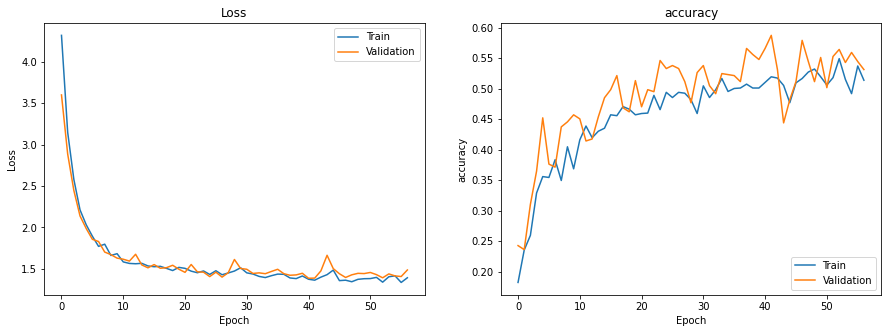

In [ ]:
loss_accuracy([history_6a])

In [ ]:
# melihat classification report
y_pred_6a = model_6a.predict(ds_test)
y_pred_6a = np.argmax(y_pred_6a, axis=1)
print(classification_report(y_test,y_pred_6a))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        81
           1       0.49      0.29      0.37        99
           2       0.38      0.48      0.42        82
           3       0.56      0.76      0.65       119
           4       0.46      0.38      0.42        97
           5       0.47      0.26      0.33        27

    accuracy                           0.52       505
   macro avg       0.51      0.48      0.48       505
weighted avg       0.51      0.52      0.50       505



In [ ]:
ds_test.class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

terlihat secara f1 score, pada label 1: glass dan label 5: trash, model memiliki nilai f1 score yang sangat rendah, sehingga akan dicoba lihat lebih dalam mengenai 2 kelas tersebut

In [ ]:
list_garbage

['glass', 'trash', 'paper', 'metal', 'plastic', 'cardboard']

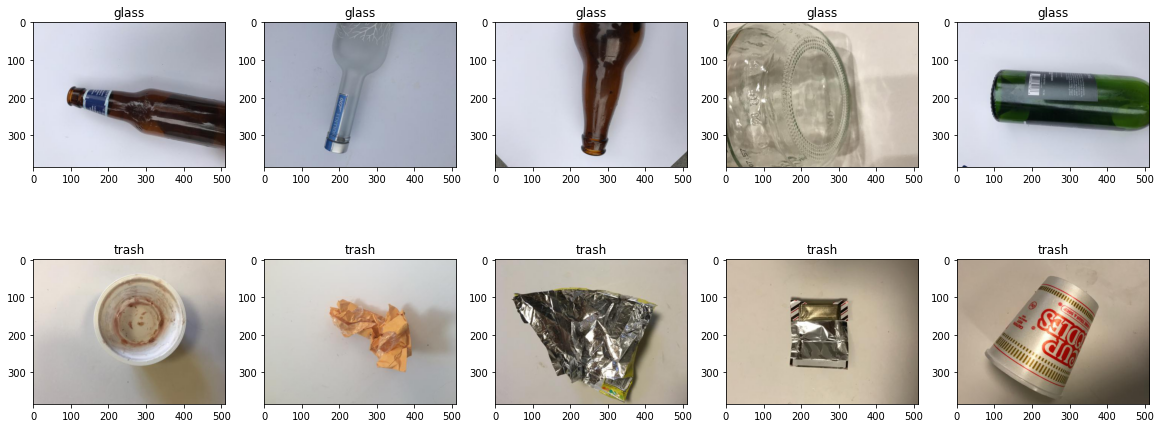

In [102]:
# Menampilkan contoh setiap jenis garbage
list_garbage_selected =['glass','trash']
ncol=5 #ini jumlah sample untuk setiap class
nrow=len(list_garbage_selected)

# Membuat dataframe sample garbage
sample_garbage = pd.DataFrame(columns=['image','label'])
for i in list_garbage_selected:
  df_sampling = df_train[df_train['label']==i].sample(ncol)
  sample_garbage = pd.concat([sample_garbage,df_sampling],ignore_index=True)
sample_garbage

# melist semua subplots
axes=[]
for x in range(nrow):
    for y in range(ncol):
        axes.append((x,y))

# menampilkan sample setiap jenis garbage
fig, ax = plt.subplots(ncols=ncol,nrows=nrow, figsize=(4*ncol,4*nrow))
for h,i in enumerate(sample_garbage['label']):
    ax[axes[h]].imshow(plt.imread(sample_garbage['new_image'][h]))
    ax[axes[h]].set_title(i)
    # ax[axes[h]].axis('off')
plt.show()

terlihat kalau data dari label trash, sangat bervariasi, isinya ada plastik, styrofoam, kertas, alumunium dll, sehingga akan dicoba didrop fitur dan melakukan training ulang.


In [ ]:
df_train_new = df_train[df_train['label']!='trash'].reset_index()
df_test_new = df_test[df_test['label']!='trash'].reset_index()
df_val_new = df_val[df_val['label']!='trash'].reset_index()

In [ ]:
df_train_new.head()

,index,image,label,first_dir,name,new_image
0,0,/content/image/Garbage classification/Garbage ...,paper,/content/image/Garbage classification/Garbage ...,paper341.jpg,/content/image/Garbage classification/Garbage ...
1,1,/content/image/Garbage classification/Garbage ...,metal,/content/image/Garbage classification/Garbage ...,metal298.jpg,/content/image/Garbage classification/Garbage ...
2,2,/content/image/Garbage classification/Garbage ...,cardboard,/content/image/Garbage classification/Garbage ...,cardboard193.jpg,/content/image/Garbage classification/Garbage ...
3,3,/content/image/Garbage classification/Garbage ...,plastic,/content/image/Garbage classification/Garbage ...,plastic216.jpg,/content/image/Garbage classification/Garbage ...
4,4,/content/image/Garbage classification/Garbage ...,glass,/content/image/Garbage classification/Garbage ...,glass451.jpg,/content/image/Garbage classification/Garbage ...


In [151]:
# menghapus direktori dataset
shutil.rmtree('/content/image')

In [ ]:
# Melakukan Unzip dan Mengekstraknya ke folder image
!unzip -q /content/garbage-classification.zip -d image 

In [ ]:
# Membuat direktori baru
for jenis in ['train','test','val']:
  for i in classes:
    os.makedirs(os.path.join(main_path,jenis,i))


In [ ]:
# move direktori
data =[df_train_new, df_test_new, df_val_new]
for df in data:
  for k,l in enumerate(df['image']):
    shutil.move(l,df['new_image'][k])

In [ ]:
classes

['glass', 'trash', 'paper', 'metal', 'plastic', 'cardboard']

In [ ]:
# menghapus direktori kosong
for i in classes:
  shutil.rmtree(os.path.join(main_path,i))
for jenis in ['train','test','val']:
  shutil.rmtree(os.path.join(main_path,jenis,'trash'))

In [ ]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'train'),
    image_size=(img_height, img_width), #ini buat nentuin image biar sama sizenya
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')

ds_val = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'val'),
    image_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')

ds_test = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'test'),
    image_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')


Found 1334 files belonging to 5 classes.
Found 573 files belonging to 5 classes.
Found 478 files belonging to 5 classes.


In [ ]:
ds_train.class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train_prefetch = ds_train.shuffle(200).cache().prefetch(buffer_size=AUTOTUNE)
ds_test_prefetch = ds_test.cache().prefetch(buffer_size=AUTOTUNE)
ds_val_prefetch = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

#data augmentation
data_augmentation = keras.Sequential(
  [RandomFlip("horizontal", input_shape=input),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ])

#Model Architecture
model_7a = Sequential()
data_augmentation,
model_7a.add(Rescaling(1./255, input_shape=input))

#Conv 1
model_7a.add(Conv2D(filters = 50, kernel_size =3, activation ='relu',
                    padding='valid',kernel_regularizer= tf.keras.regularizers.L2(0.01),
                    input_shape=input))
model_7a.add(MaxPooling2D(pool_size=2 )) 
model_7a.add(Dropout(0.4))

#Conv 2
model_7a.add(Conv2D(filters = 80, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_7a.add(MaxPooling2D(pool_size=2)) 
model_7a.add(Dropout(0.4))

#Conv 3
model_7a.add(Conv2D(filters = 50, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_7a.add(MaxPooling2D(pool_size=2)) 
model_7a.add(Dropout(0.4))

#Conv 4
model_7a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_7a.add(MaxPooling2D(pool_size=2)) 
model_7a.add(Dropout(0.4))

#Flatten
model_7a.add(Flatten())
model_7a.add(Dense(units=80, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_7a.add(Dropout(0.30))
model_7a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_7a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# callbacks
callback_7a = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_7a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_7a = model_7a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_7a, verbose = 1)

Epoch 1/100
42/42 [==============================] - 20s 131ms/step - loss: 4.0728 - accuracy: 0.2376 - val_loss: 3.2525 - val_accuracy: 0.2496
Epoch 2/100
42/42 [==============================] - 4s 93ms/step - loss: 2.7749 - accuracy: 0.2789 - val_loss: 2.4260 - val_accuracy: 0.2827
Epoch 3/100
42/42 [==============================] - 4s 93ms/step - loss: 2.1810 - accuracy: 0.3208 - val_loss: 2.0681 - val_accuracy: 0.3141
Epoch 4/100
42/42 [==============================] - 4s 92ms/step - loss: 1.9021 - accuracy: 0.3606 - val_loss: 1.8485 - val_accuracy: 0.3613
Epoch 5/100
42/42 [==============================] - 4s 92ms/step - loss: 1.7322 - accuracy: 0.3636 - val_loss: 1.7293 - val_accuracy: 0.3927
Epoch 6/100
42/42 [==============================] - 4s 92ms/step - loss: 1.6363 - accuracy: 0.3756 - val_loss: 1.6531 - val_accuracy: 0.3647
Epoch 7/100
42/42 [==============================] - 4s 91ms/step - loss: 1.5703 - accuracy: 0.3891 - val_loss: 1.6062 - val_accuracy: 0.3578
Epoc

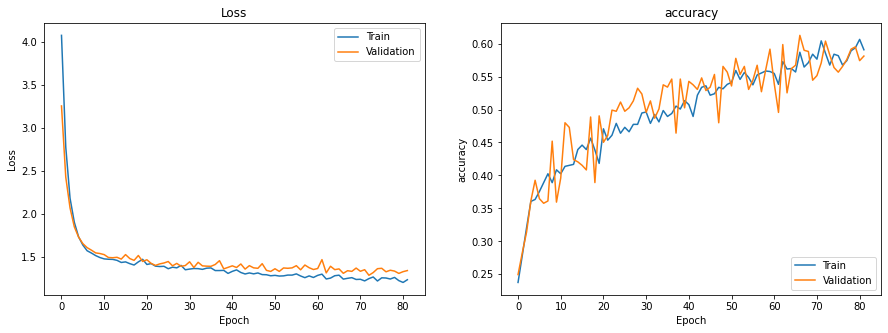

In [ ]:
loss_accuracy([history_7a])

In [ ]:
# Mengembalikan label y_test dari batchdataset
y_test = np.argmax(np.concatenate([y for x, y in ds_test], axis=0),axis=1)

In [ ]:
# melihat classification report
y_pred_7a = model_7a.predict(ds_test)
y_pred_7a = np.argmax(y_pred_7a, axis=1)
print(classification_report(y_test,y_pred_7a))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70        81
           1       0.40      0.75      0.52        99
           2       0.52      0.28      0.37        82
           3       0.73      0.67      0.70       119
           4       0.69      0.34      0.46        97

    accuracy                           0.56       478
   macro avg       0.60      0.56      0.55       478
weighted avg       0.61      0.56      0.56       478



model akan dilakukan training lebih lanjut untuk melihat apakah masih bisa lebih baik atau tidak

In [ ]:
# callbacks
model_7b =model_7a
callback_7b = [
              EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 20, verbose = 1),
              ModelCheckpoint('model_7b.hdf5', monitor = 'accuracy', save_best_only =True)
]
history_7b = model_7b.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_7b, verbose = 1)

Epoch 1/100
42/42 [==============================] - 4s 92ms/step - loss: 1.1879 - accuracy: 0.6057 - val_loss: 1.2837 - val_accuracy: 0.6021
Epoch 2/100
42/42 [==============================] - 4s 90ms/step - loss: 1.2178 - accuracy: 0.5945 - val_loss: 1.3910 - val_accuracy: 0.5410
Epoch 3/100
42/42 [==============================] - 4s 90ms/step - loss: 1.2589 - accuracy: 0.5840 - val_loss: 1.3692 - val_accuracy: 0.5532
Epoch 4/100
42/42 [==============================] - 4s 90ms/step - loss: 1.2373 - accuracy: 0.5720 - val_loss: 1.2998 - val_accuracy: 0.5881
Epoch 5/100
42/42 [==============================] - 4s 90ms/step - loss: 1.2229 - accuracy: 0.5795 - val_loss: 1.3109 - val_accuracy: 0.6230
Epoch 6/100
42/42 [==============================] - 4s 91ms/step - loss: 1.2069 - accuracy: 0.6019 - val_loss: 1.2776 - val_accuracy: 0.6195
Epoch 7/100
42/42 [==============================] - 4s 91ms/step - loss: 1.1936 - accuracy: 0.6222 - val_loss: 1.3078 - val_accuracy: 0.5759
Epoch 

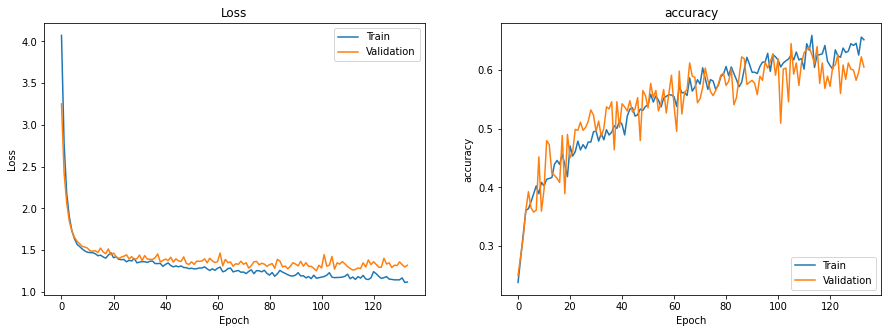

In [ ]:
loss_accuracy([history_7a,history_7b])

In [ ]:
# melihat classification report
y_pred_7b = model_7b.predict(ds_test)
y_pred_7b = np.argmax(y_pred_7b, axis=1)
print(classification_report(y_test,y_pred_7b))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68        81
           1       0.45      0.78      0.57        99
           2       0.51      0.40      0.45        82
           3       0.78      0.64      0.70       119
           4       0.69      0.38      0.49        97

    accuracy                           0.59       478
   macro avg       0.61      0.58      0.58       478
weighted avg       0.62      0.59      0.58       478



In [ ]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'train'),
    image_size=(img_height, img_width), #ini buat nentuin image biar sama sizenya
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')

ds_val = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'val'),
    image_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')

ds_test = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(main_path,'test'),
    image_size=(img_height, img_width),
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    color_mode ='rgb',
    label_mode='categorical')


Found 1334 files belonging to 5 classes.
Found 573 files belonging to 5 classes.
Found 478 files belonging to 5 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train_prefetch = ds_train.shuffle(200).cache().prefetch(buffer_size=AUTOTUNE)
ds_test_prefetch = ds_test.cache().prefetch(buffer_size=AUTOTUNE)
ds_val_prefetch = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
input = [img_height, img_width,1]
num_classes = len(ds_train.class_names)

#data augmentation
data_augmentation = keras.Sequential(
  [RandomFlip("horizontal", input_shape=input),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ])

#Model Architecture
model_8a = Sequential()
data_augmentation,
model_8a.add(Rescaling(1./255, input_shape=input))

#Conv 1
model_8a.add(Conv2D(filters = 50, kernel_size =3, activation ='relu',
                    padding='valid',kernel_regularizer= tf.keras.regularizers.L2(0.01),
                    input_shape=input))
model_8a.add(MaxPooling2D(pool_size=2 )) 
model_8a.add(Dropout(0.4))

#Conv 2
model_8a.add(Conv2D(filters = 80, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_8a.add(MaxPooling2D(pool_size=2)) 
model_8a.add(Dropout(0.4))

#Conv 3
model_8a.add(Conv2D(filters = 50, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_8a.add(MaxPooling2D(pool_size=2)) 
model_8a.add(Dropout(0.4))

#Conv 4
model_8a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='valid',kernel_regularizer=tf.keras.regularizers.L2(0.01))) 
model_8a.add(MaxPooling2D(pool_size=2)) 
model_8a.add(Dropout(0.4))

#Flatten
model_8a.add(Flatten())
model_8a.add(Dense(units=80, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model_8a.add(Dropout(0.30))
model_8a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_8a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# callbacks
callback_8a = [
              EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15, verbose = 1),
              ModelCheckpoint('model_8a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]
history_8a = model_8a.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_8a, verbose = 1)

Epoch 1/100
42/42 [==============================] - 6s 98ms/step - loss: 3.9624 - accuracy: 0.2399 - val_loss: 3.1353 - val_accuracy: 0.2496
Epoch 2/100
42/42 [==============================] - 3s 82ms/step - loss: 2.6896 - accuracy: 0.2249 - val_loss: 2.3504 - val_accuracy: 0.2496
Epoch 3/100
42/42 [==============================] - 3s 82ms/step - loss: 2.1452 - accuracy: 0.2466 - val_loss: 2.0048 - val_accuracy: 0.2496
Epoch 4/100
42/42 [==============================] - 3s 82ms/step - loss: 1.8948 - accuracy: 0.2601 - val_loss: 1.8362 - val_accuracy: 0.2496
Epoch 5/100
42/42 [==============================] - 4s 84ms/step - loss: 1.7637 - accuracy: 0.2684 - val_loss: 1.7565 - val_accuracy: 0.2513
Epoch 6/100
42/42 [==============================] - 3s 83ms/step - loss: 1.6972 - accuracy: 0.2819 - val_loss: 1.6922 - val_accuracy: 0.3002
Epoch 7/100
42/42 [==============================] - 3s 83ms/step - loss: 1.6477 - accuracy: 0.2916 - val_loss: 1.6723 - val_accuracy: 0.3106
Epoch 

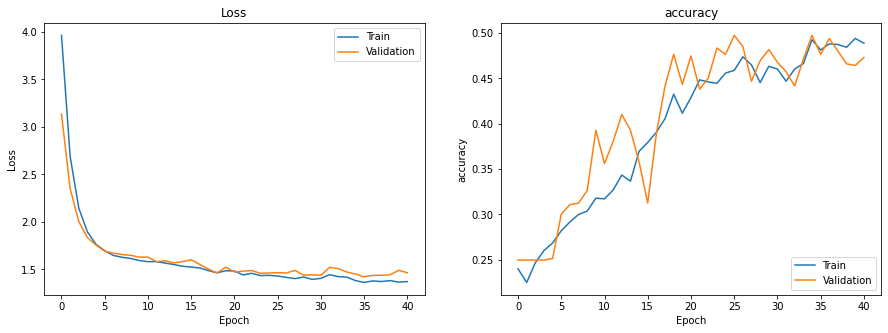

In [ ]:
loss_accuracy([history_8a])

In [ ]:
# callbacks
model_8b =model_8a
callback_8b = [
              EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 20, verbose = 1),
              ModelCheckpoint('model_8b.hdf5', monitor = 'accuracy', save_best_only =True)
]
history_8b = model_8b.fit(ds_train_prefetch, batch_size = BATCH, epochs =100, validation_data=ds_val_prefetch, callbacks=callback_8b, verbose = 1)

Epoch 1/100
42/42 [==============================] - 3s 83ms/step - loss: 1.3635 - accuracy: 0.5015 - val_loss: 1.4772 - val_accuracy: 0.4764
Epoch 2/100
42/42 [==============================] - 3s 81ms/step - loss: 1.3522 - accuracy: 0.4993 - val_loss: 1.4423 - val_accuracy: 0.4817
Epoch 3/100
42/42 [==============================] - 3s 81ms/step - loss: 1.3587 - accuracy: 0.4970 - val_loss: 1.4796 - val_accuracy: 0.4520
Epoch 4/100
42/42 [==============================] - 3s 82ms/step - loss: 1.3672 - accuracy: 0.5172 - val_loss: 1.4869 - val_accuracy: 0.4660
Epoch 5/100
42/42 [==============================] - 3s 81ms/step - loss: 1.3576 - accuracy: 0.5060 - val_loss: 1.4741 - val_accuracy: 0.4764
Epoch 6/100
42/42 [==============================] - 3s 81ms/step - loss: 1.3726 - accuracy: 0.5052 - val_loss: 1.5608 - val_accuracy: 0.4520
Epoch 7/100
42/42 [==============================] - 3s 81ms/step - loss: 1.3669 - accuracy: 0.4895 - val_loss: 1.5325 - val_accuracy: 0.4433
Epoch 

In [ ]:
# melihat classification report
y_pred_8a = model_8a.predict(ds_test)
y_pred_8a = np.argmax(y_pred_8a, axis=1)
print(classification_report(y_test,y_pred_8a))

              precision    recall  f1-score   support

           0       0.40      0.75      0.52        81
           1       0.34      0.52      0.41        99
           2       0.48      0.27      0.34        82
           3       0.64      0.41      0.50       119
           4       0.66      0.38      0.48        97

    accuracy                           0.46       478
   macro avg       0.51      0.47      0.45       478
weighted avg       0.52      0.46      0.46       478



terlihat ini sudah maksimalnya dari data yang ada, maka perlu konsiderasi untuk meningkatkan performa dari data cleaning

In [ ]:
input = [img_height, img_width,3]
num_classes = len(ds_train.class_names)

# #data augmentation
# data_augmentation = keras.Sequential(
#   [RandomFlip("horizontal", input_shape=input),
#     RandomRotation(0.1),
#     RandomZoom(0.1),
#   ])

#Model Architecture
model_9a = Sequential()
# data_augmentation,
model_9a.add(Rescaling(1./255, input_shape=input))

#Conv 1
model_9a.add(Conv2D(filters = 64, kernel_size =3, activation ='relu',
                    padding='same'))
model_9a.add(MaxPooling2D(pool_size=2 )) 
model_9a.add(Dropout(0.4))

#Conv 2
model_9a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='valid')) 
model_9a.add(MaxPooling2D(pool_size=2)) 
model_9a.add(Dropout(0.4))

#Conv 3
model_9a.add(Conv2D(filters =32, kernel_size =3,  activation ='relu',padding='valid')) 
model_9a.add(MaxPooling2D(pool_size=2)) 
model_9a.add(Dropout(0.4))

# #Conv 4
# model_9a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='valid')) 
# model_9a.add(MaxPooling2D(pool_size=2)) 
# model_9a.add(Dropout(0.4))

#Flatten
model_9a.add(Flatten())
model_9a.add(Dense(units=60, activation='relu'))
model_9a.add(Dropout(0.30))
model_9a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_9a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])



In [ ]:
# callbacks
model_9a =model_9a
callback_9a = [
              EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 20, verbose = 1),
              ModelCheckpoint('model_9a.hdf5', monitor = 'accuracy', save_best_only =True)
]
history_9a = model_9a.fit(ds_train, batch_size = BATCH, epochs =100, validation_data=ds_val, callbacks=callback_9a, verbose = 1)

Epoch 1/100
42/42 [==============================] - 6s 115ms/step - loss: 1.8621 - accuracy: 0.2249 - val_loss: 1.6067 - val_accuracy: 0.2496
Epoch 2/100
42/42 [==============================] - 5s 108ms/step - loss: 1.5919 - accuracy: 0.2534 - val_loss: 1.5838 - val_accuracy: 0.2024
Epoch 3/100
42/42 [==============================] - 5s 110ms/step - loss: 1.5756 - accuracy: 0.2631 - val_loss: 1.5587 - val_accuracy: 0.4241
Epoch 4/100
42/42 [==============================] - 5s 108ms/step - loss: 1.4937 - accuracy: 0.3418 - val_loss: 1.4909 - val_accuracy: 0.3560
Epoch 5/100
42/42 [==============================] - 5s 108ms/step - loss: 1.4549 - accuracy: 0.3433 - val_loss: 1.4527 - val_accuracy: 0.3944
Epoch 6/100
42/42 [==============================] - 5s 109ms/step - loss: 1.4112 - accuracy: 0.3486 - val_loss: 1.4116 - val_accuracy: 0.3578
Epoch 7/100
42/42 [==============================] - 5s 109ms/step - loss: 1.4133 - accuracy: 0.3516 - val_loss: 1.4471 - val_accuracy: 0.4293

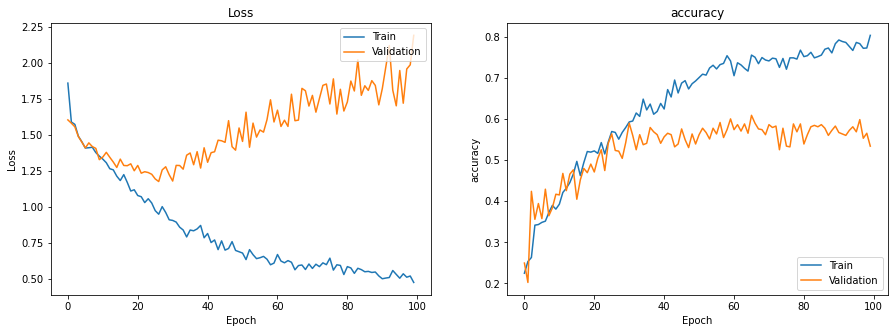

In [ ]:
loss_accuracy([history_9a])

## Mencoba Perbedaan Model yang datanya digenerate dari Flow from dataframe

In [29]:
input = [img_height, img_width,3]
num_classes = len(ds_train_df.class_indices)

model_10a = Sequential()
# Conv 1
# model_10a.add(CenterCrop(height =300, width=300, input_shape=input))
# model_10a.add(Resizing(300,300,input_shape=input))
model_10a.add(Conv2D(filters = 32, kernel_size =3, activation ='relu', padding='same', input_shape=input))
# model_10a.add(BatchNormalization())
model_10a.add(MaxPooling2D(pool_size=2 )) 
# model_10a.add(Dropout(0.3))

#Conv 2
model_10a.add(Conv2D(filters = 64, kernel_size =3,  activation ='relu',padding='same')) 
# model_10a.add(BatchNormalization())
model_10a.add(MaxPooling2D(pool_size=2)) 
# model_10a.add(Dropout(0.3))

#Conv 3
model_10a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
# model_10a.add(BatchNormalization())
model_10a.add(MaxPooling2D(pool_size=2)) 
# model_10a.add(Dropout(0.3))

#Conv 4
model_10a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
# model_10a.add(BatchNormalization())
model_10a.add(MaxPooling2D(pool_size=2)) 
# model_10a.add(Dropout(0.3))

#Flatten
model_10a.add(Flatten())
model_10a.add(Dense(units=64, activation='relu'))
# model_10a.add(Dropout(0.20))
model_10a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_10a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

# callbacks
callback_10a = [
            #   EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, verbose = 1),
              ModelCheckpoint('model_10a.hdf5', monitor = 'val_accuracy', save_best_only =True)
]

In [30]:
history_10a = model_10a.fit(ds_train_df, batch_size = BATCH, epochs =100, validation_data=ds_val_df, callbacks=callback_10a, verbose = 1)

Epoch 1/100
45/45 [==============================] - 41s 664ms/step - loss: 1.6822 - accuracy: 0.2488 - val_loss: 1.5647 - val_accuracy: 0.3086
Epoch 2/100
45/45 [==============================] - 30s 662ms/step - loss: 1.5684 - accuracy: 0.3381 - val_loss: 1.4939 - val_accuracy: 0.3548
Epoch 3/100
45/45 [==============================] - 30s 662ms/step - loss: 1.4520 - accuracy: 0.3962 - val_loss: 1.4091 - val_accuracy: 0.4125
Epoch 4/100
45/45 [==============================] - 30s 665ms/step - loss: 1.4176 - accuracy: 0.3962 - val_loss: 1.4579 - val_accuracy: 0.4043
Epoch 5/100
45/45 [==============================] - 30s 663ms/step - loss: 1.4161 - accuracy: 0.4082 - val_loss: 1.3692 - val_accuracy: 0.4719
Epoch 6/100
45/45 [==============================] - 30s 660ms/step - loss: 1.3356 - accuracy: 0.4564 - val_loss: 1.2596 - val_accuracy: 0.4983
Epoch 7/100
45/45 [==============================] - 30s 663ms/step - loss: 1.2689 - accuracy: 0.4741 - val_loss: 1.2620 - val_accuracy:

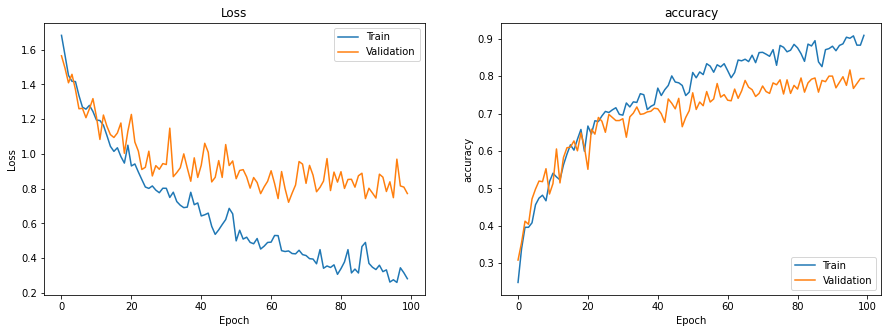

In [34]:
loss_accuracy([history_10a])

In [35]:
# melihat classification report
y_pred_10a = model_10a.predict(ds_test_df)
y_pred_10a = np.argmax(y_pred_10a, axis=1)
print(classification_report(ds_test_df.classes, y_pred_10a))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        81
           1       0.80      0.75      0.77        99
           2       0.76      0.70      0.73        82
           3       0.81      0.92      0.86       119
           4       0.83      0.78      0.80        97
           5       0.63      0.63      0.63        27

    accuracy                           0.80       505
   macro avg       0.78      0.77      0.77       505
weighted avg       0.80      0.80      0.80       505



In [68]:
keys= ds_train_df.class_indices.keys()

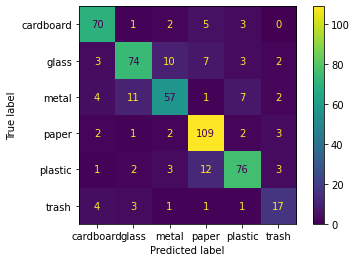

In [69]:
cm_10a = confusion_matrix(ds_test_df.classes, y_pred_10a)
disp_10a = ConfusionMatrixDisplay(confusion_matrix=cm_10a, display_labels=keys)
disp_10a.plot()
plt.show()

terlihat data yang digenerate dari flow from dataframe lebih bagus dari grafik trainingnya dan juga classification reportnya, namun karena masih overfit, maka akan ditambahkan sedikit dropout

In [39]:
input = [img_height, img_width,3]
num_classes = len(ds_train_df.class_indices)

model_11a = Sequential()
# Conv 1
model_11a.add(Conv2D(filters = 32, kernel_size =3, activation ='relu', padding='same', input_shape=input))
model_11a.add(MaxPooling2D(pool_size=2 )) 
model_11a.add(Dropout(0.2))

#Conv 2
model_11a.add(Conv2D(filters = 64, kernel_size =3,  activation ='relu',padding='same')) 
model_11a.add(MaxPooling2D(pool_size=2)) 
model_11a.add(Dropout(0.2))

#Conv 3
model_11a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
model_11a.add(MaxPooling2D(pool_size=2)) 
model_11a.add(Dropout(0.2))

#Conv 4
model_11a.add(Conv2D(filters = 32, kernel_size =3,  activation ='relu',padding='same')) 
model_11a.add(MaxPooling2D(pool_size=2)) 
model_11a.add(Dropout(0.2))

#Flatten
model_11a.add(Flatten())
model_11a.add(Dense(units=64, activation='relu'))
model_11a.add(Dropout(0.10))
model_11a.add(Dense(units=num_classes, activation ='softmax')) # karena categorical classification

model_11a.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

# callbacks
callback_11a = [
              EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 15, verbose = 1),
              ModelCheckpoint('model_11a.hdf5', monitor = 'val_loss', save_best_only =True)
]

In [40]:
history_11a = model_11a.fit(ds_train_df, batch_size = BATCH, epochs =100, validation_data=ds_val_df, callbacks=callback_11a, verbose = 1)

Epoch 1/100
45/45 [==============================] - 31s 665ms/step - loss: 1.7342 - accuracy: 0.2225 - val_loss: 1.6669 - val_accuracy: 0.3762
Epoch 2/100
45/45 [==============================] - 30s 662ms/step - loss: 1.6271 - accuracy: 0.3012 - val_loss: 1.6192 - val_accuracy: 0.3812
Epoch 3/100
45/45 [==============================] - 30s 664ms/step - loss: 1.5312 - accuracy: 0.3501 - val_loss: 1.5488 - val_accuracy: 0.3614
Epoch 4/100
45/45 [==============================] - 30s 662ms/step - loss: 1.5161 - accuracy: 0.3643 - val_loss: 1.5908 - val_accuracy: 0.3828
Epoch 5/100
45/45 [==============================] - 30s 661ms/step - loss: 1.4613 - accuracy: 0.3926 - val_loss: 1.4508 - val_accuracy: 0.3993
Epoch 6/100
45/45 [==============================] - 30s 658ms/step - loss: 1.4179 - accuracy: 0.4047 - val_loss: 1.5042 - val_accuracy: 0.3597
Epoch 7/100
45/45 [==============================] - 30s 665ms/step - loss: 1.3564 - accuracy: 0.4245 - val_loss: 1.4160 - val_accuracy:

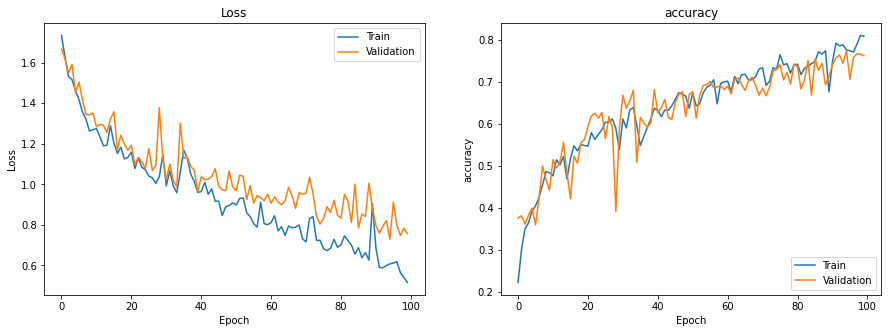

In [41]:
loss_accuracy([history_11a])

In [42]:
# melihat classification report
y_pred_11a = model_11a.predict(ds_test_df)
y_pred_11a = np.argmax(y_pred_11a, axis=1)
print(classification_report(ds_test_df.classes, y_pred_11a))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        81
           1       0.75      0.74      0.74        99
           2       0.75      0.68      0.71        82
           3       0.85      0.84      0.85       119
           4       0.67      0.75      0.71        97
           5       0.54      0.70      0.61        27

    accuracy                           0.76       505
   macro avg       0.74      0.75      0.75       505
weighted avg       0.77      0.76      0.77       505



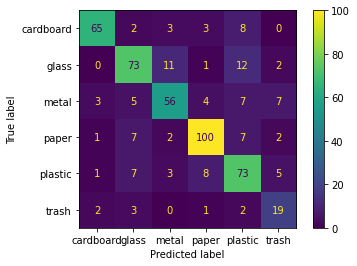

In [70]:
cm_11a = confusion_matrix(ds_test_df.classes, y_pred_11a)
disp_11a = ConfusionMatrixDisplay(confusion_matrix=cm_11a, display_labels=keys)
disp_11a.plot()
plt.show()

Terlihat masih bisa dilakukan training lebih lanjut, maka akan dilakukan training sekali lagi dengan epoch 60

In [51]:
# Melakukan training lebih lanjut
model_11b = model_11a
callback_11b = [
              EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 8, verbose = 1),
              ModelCheckpoint('model_11b.hdf5', monitor = 'val_loss', save_best_only =True)]
history_11b = model_11b.fit(ds_train_df, batch_size = BATCH, epochs =60, validation_data=ds_val_df, callbacks=callback_11b, verbose = 1)

Epoch 1/60
45/45 [==============================] - 30s 665ms/step - loss: 0.6208 - accuracy: 0.7682 - val_loss: 0.8065 - val_accuracy: 0.7640
Epoch 2/60
45/45 [==============================] - 30s 657ms/step - loss: 0.5677 - accuracy: 0.7881 - val_loss: 0.9094 - val_accuracy: 0.6898
Epoch 3/60
45/45 [==============================] - 30s 656ms/step - loss: 0.5472 - accuracy: 0.8023 - val_loss: 0.8589 - val_accuracy: 0.7492
Epoch 4/60
45/45 [==============================] - 30s 666ms/step - loss: 0.5532 - accuracy: 0.7945 - val_loss: 0.7839 - val_accuracy: 0.7624
Epoch 5/60
45/45 [==============================] - 29s 655ms/step - loss: 0.5397 - accuracy: 0.7980 - val_loss: 0.7844 - val_accuracy: 0.7508
Epoch 6/60
45/45 [==============================] - 30s 665ms/step - loss: 0.6315 - accuracy: 0.7768 - val_loss: 0.7797 - val_accuracy: 0.7558
Epoch 7/60
45/45 [==============================] - 30s 660ms/step - loss: 0.5809 - accuracy: 0.7895 - val_loss: 0.7846 - val_accuracy: 0.7294

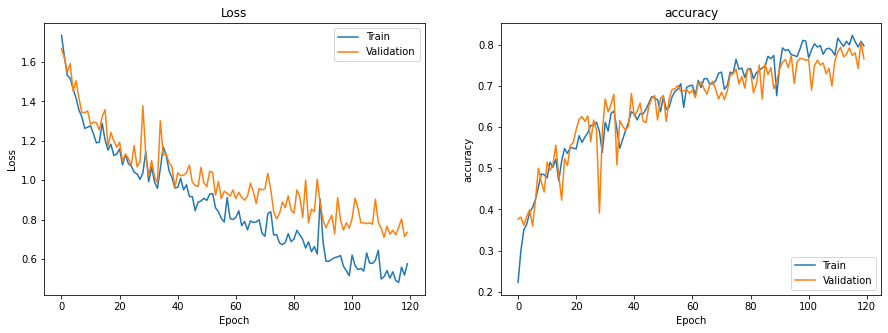

In [52]:
loss_accuracy([history_11a,history_11b])

In [53]:
# melihat classification report
y_pred_11b = model_11b.predict(ds_test_df)
y_pred_11b = np.argmax(y_pred_11b, axis=1)
print(classification_report(ds_test_df.classes, y_pred_11b))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        81
           1       0.81      0.60      0.69        99
           2       0.66      0.76      0.70        82
           3       0.88      0.84      0.86       119
           4       0.68      0.79      0.73        97
           5       0.56      0.81      0.67        27

    accuracy                           0.76       505
   macro avg       0.75      0.77      0.75       505
weighted avg       0.78      0.76      0.77       505



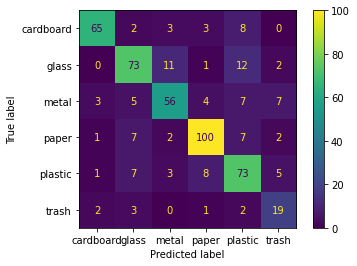

In [72]:
# Melihat confusion matrix untuk memandingkan model 11a dan 11b karena akurasinya dan classification reportnya mirip
disp_11a.plot()
plt.show()

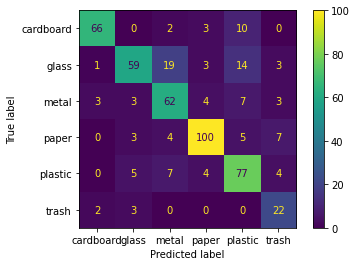

In [ ]:
# Melihat confusion matrix untuk memandingkan model 11a dan 11b karena akurasinya dan classification reportnya mirip
cm_11b = confusion_matrix(ds_test_df.classes, y_pred_11b)
disp_11b = ConfusionMatrixDisplay(confusion_matrix=cm_11b, display_labels=keys)
disp_11b.plot()
plt.show()

- Diputuskan untuk memilih model 11b karena nilai false negative pada trash lebih sedikit daripada model 11a, ini memungkinkan klasifikasi sampah yang tidak bisa didaur ulang menjadi lebih baik.
- Pertimbangannya kalau sampah daur ulang seperti cardboard dan glass dikategorikan tidak bisa didaur ulang (trash), maka hanya nilai kerugiannya lebih kecil daripada memasukan trash ke kategori yang bisa daur ulang

# Data Inference

In [184]:
# melihat class
ds_train_df.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [182]:
# Melihat dictionary keys
keys

dict_keys(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

In [185]:
# memasukan ke dalam list agar callable
kelas = []
for i in keys:
  kelas.append(i)
kelas

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [161]:
df_inf

,image,label,first_dir,name,new_image
0,/content/image/Garbage classification/Garbage ...,trash,/content/image/Garbage classification/Garbage ...,trash54.jpg,/content/image/Garbage classification/Garbage ...
1,/content/image/Garbage classification/Garbage ...,cardboard,/content/image/Garbage classification/Garbage ...,cardboard85.jpg,/content/image/Garbage classification/Garbage ...
2,/content/image/Garbage classification/Garbage ...,plastic,/content/image/Garbage classification/Garbage ...,plastic35.jpg,/content/image/Garbage classification/Garbage ...
3,/content/image/Garbage classification/Garbage ...,paper,/content/image/Garbage classification/Garbage ...,paper543.jpg,/content/image/Garbage classification/Garbage ...
4,/content/image/Garbage classification/Garbage ...,glass,/content/image/Garbage classification/Garbage ...,glass275.jpg,/content/image/Garbage classification/Garbage ...


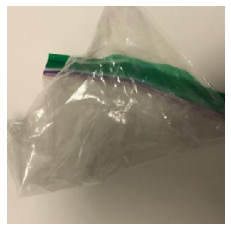

[[0.02945852 0.13959917 0.00497077 0.00436492 0.2919267  0.52967995]]
probabilitas = 52.967995405197144 %
kelas = 5
prediksi = trash
aktual = trash


In [191]:
# Mencoba memprediksi data inference 0
uploaded = [df_inf['new_image'][0]]

for fn in uploaded:
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])
  print('aktual =',df_inf['label'][0])

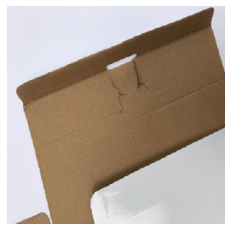

[[9.9873930e-01 3.5139776e-09 1.2549128e-06 1.2194654e-03 1.9969597e-09
  4.0021427e-05]]
probabilitas = 99.87393021583557 %
kelas = 0
prediksi = cardboard
aktual = cardboard


In [192]:
# Mencoba memprediksi data inference 1
uploaded = [df_inf['new_image'][1]]

for fn in uploaded:
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])
  print('aktual =',df_inf['label'][1])

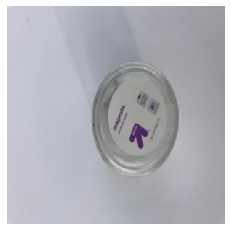

[[7.1303644e-03 2.2236379e-02 8.2567002e-04 1.3558612e-03 9.6766984e-01
  7.8185351e-04]]
probabilitas = 96.76698446273804 %
kelas = 4
prediksi = plastic
aktual = plastic


In [193]:
# Mencoba memprediksi data inference 2
uploaded = [df_inf['new_image'][2]]

for fn in uploaded:
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])
  print('aktual =',df_inf['label'][2])

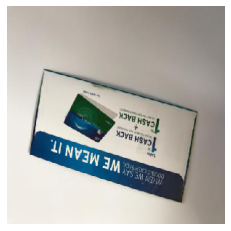

[[3.5185728e-02 1.7717757e-04 4.1060373e-03 9.4520664e-01 1.4090228e-02
  1.2341145e-03]]
probabilitas = 94.52066421508789 %
kelas = 3
prediksi = paper
aktual = paper


In [194]:
# Mencoba memprediksi data inference 3
uploaded = [df_inf['new_image'][3]]

for fn in uploaded:
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])
  print('aktual =',df_inf['label'][3])

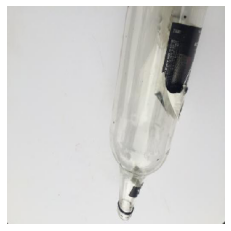

[[0.06545176 0.14034288 0.03064683 0.53517514 0.19142228 0.03696109]]
probabilitas = 53.51751446723938 %
kelas = 3
prediksi = paper
aktual = glass


In [195]:
# Mencoba memprediksi data inference 4
uploaded = [df_inf['new_image'][4]]

for fn in uploaded:
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])
  print('aktual =',df_inf['label'][4])

 Terlihat dari 5 data inference ada 1 prediksi yang salah, yaitu gambar botol yang diprediksi kertas. Namun, bisa dilihat kalau modelpun masih ragu dalam memprediksinya, karena probabilitas hasilnya hanya 53%.

Saving c0805d6b73a23d4790177583edfe725c.jpg to c0805d6b73a23d4790177583edfe725c.jpg


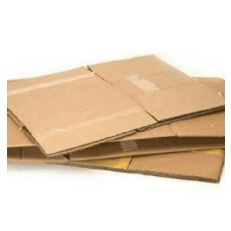

[[9.0363234e-01 1.0717388e-04 1.4940371e-03 5.1724341e-02 3.6574181e-04
  4.2676408e-02]]
probabilitas = 90.36323428153992 %
kelas = 0
prediksi = cardboard


In [201]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])

Saving 158704063663429_cecc9ddc-2143-429d-be6b-c7dab4ee6bed.jpg to 158704063663429_cecc9ddc-2143-429d-be6b-c7dab4ee6bed.jpg


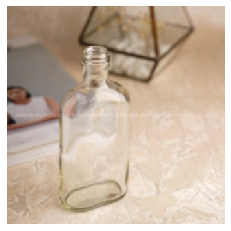

[[0.04811365 0.44220465 0.42412192 0.07856956 0.00338888 0.00360129]]
probabilitas = 44.220465421676636 %
kelas = 1
prediksi = glass


In [206]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])

Saving rfid-tags-on-metal-surfaces-header.jpg to rfid-tags-on-metal-surfaces-header.jpg


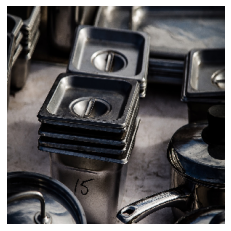

[[1.8406853e-07 7.1784056e-10 9.9999976e-01 4.3389185e-21 8.1191096e-12
  5.5825022e-18]]
probabilitas = 99.99997615814209 %
kelas = 2
prediksi = metal


In [207]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])

Saving images-3.fit_lim.size_2000x.v1652995523.jpg to images-3.fit_lim.size_2000x.v1652995523.jpg


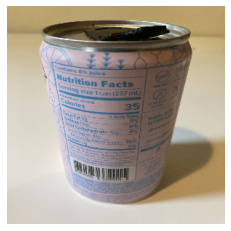

[[1.1151630e-02 2.8548196e-02 9.5368940e-01 3.8899519e-04 6.1509958e-03
  7.0779701e-05]]
probabilitas = 95.36893963813782 %
kelas = 2
prediksi = metal


In [208]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])

Saving 1200px-Empty_Wine_bottle.jpg to 1200px-Empty_Wine_bottle (1).jpg


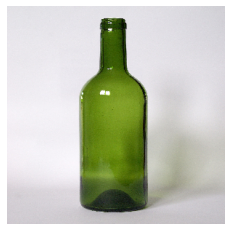

[[1.1219749e-06 2.9187786e-06 3.7249879e-06 2.1596275e-02 9.7810215e-01
  2.9386845e-04]]
probabilitas = 97.81021475791931 %
kelas = 4
prediksi = plastic


In [211]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(300,300)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]
  x = x*1./255
  images = np.vstack([x])
  classes_predict = model_11b.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  max = np.argmax(classes_predict, axis=1)
  print(classes_predict) 
  print('probabilitas =',classes_predict[0][max[0]]*100,'%')
  print('kelas =',max[0])
  print('prediksi =',kelas[max[0]])

Terlihat dari beberapa data external, tetap terdapat kesalahan pada model, sehingga dapat salah memprediksi material dari sample.